In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

In [2]:
def update_H(W, H, V):
    numerator = W.T.dot(V)
    denominator = W.T.dot(W).dot(H) + 1e-10
    H = H*(numerator / denominator)
    return H

def update_W(W, H, V):
    numerator = V.dot(H.T)
    denominator = W.dot(H).dot(H.T) + 1e-10
    W = W*(numerator / denominator)
    return W

In [3]:
def do_nnmf(V, rank=10, iter=10):
    
    # Initialize 
    n, m = V.shape
    
    W = np.abs(np.random.randn(1, n, rank))[0]
    H = np.abs(np.random.randn(1, rank, m))[0]
    
    for i in range(iter):
        H = update_H(W, H, V)
        W = update_W(W, H, V)

    return H, W

In [4]:
img = plt.imread("./images/small.jpg")
V = img[:, :, 1] # only use one ccolor channel

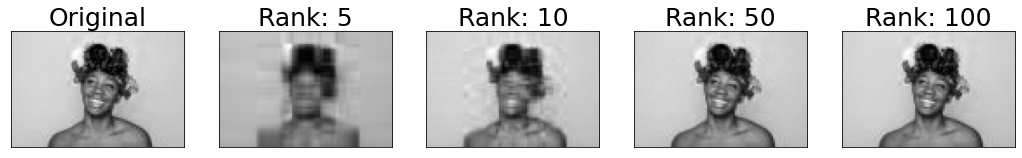

In [5]:
ranks_to_test = [5, 10, 50, 100]

n_plots = len(ranks_to_test) + 1
fig, ax = plt.subplots(1, n_plots, figsize=[18, 5])

# Plot original image as reference
ax[0].imshow(V, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original', fontsize=25)

n = 1
for i in ranks_to_test:
    
    H, W = do_nnmf(V, rank=i, iter=1000)
    V_rec = W.dot(H)

    ax[n].imshow(V_rec, cmap='gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Rank: {}'.format(i), fontsize=25)

    n += 1
    
plt.show()

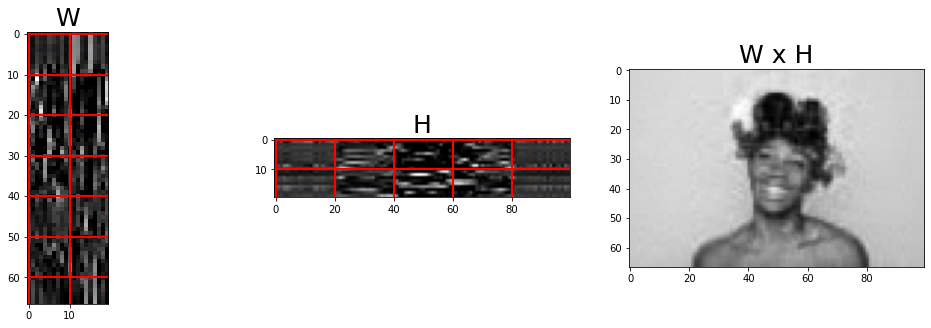

In [6]:
H, W = do_nnmf(V, rank=20, iter=1000)
V_rec = W.dot(H)

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

ax[0].imshow(W, cmap='gray')
ax[0].grid(color='r', linestyle='-', linewidth=2)
ax[0].set_title('W', fontsize=25)

ax[1].imshow(H, cmap='gray')
ax[1].grid(color='r', linestyle='-', linewidth=2)
ax[1].set_title('H', fontsize=25)

ax[2].imshow(V_rec, cmap='gray')
ax[2].set_title('W x H', fontsize=25)

plt.show()

Dataset: https://www.kaggle.com/joseguzman/waveforms

In [7]:
data = pd.read_csv('./data/waveforms.csv')

label = data.iloc[:, 0]
organoid = data.iloc[:, -1]
data = data.iloc[:, 1:-1].to_numpy()
data = tmp_data = data.T + np.abs(np.min(data))

Notebook: https://www.kaggle.com/joseguzman/spike-classification-based-on-waveforms

Related: https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316

In [8]:
n_rank = 3
H, W = do_nnmf(tmp_data, rank=n_rank, iter=10000)

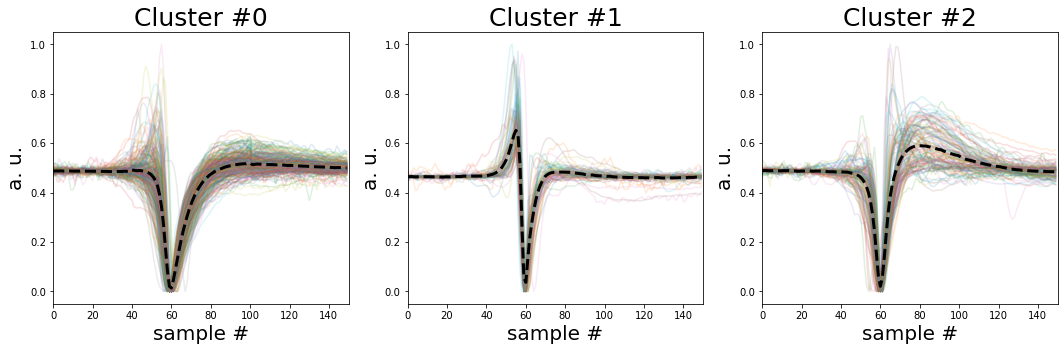

In [9]:
cluster_id = []
for x in range(H.shape[1]):
    cluster_id.append(np.where(np.max(H[:, x]) == H[:, x])[0][0])
    
fig, ax = plt.subplots(1, n_rank, figsize=[18, 5])

for cluster in range(n_rank):
    cluster_index = np.where([x == cluster for x in cluster_id])

    waveforms = data.T[cluster_index].T
    waveforms = waveforms / np.max(waveforms)
    mean_waveform = np.mean(waveforms, axis=1)

    ax[cluster].plot(waveforms,alpha=0.15)
    ax[cluster].plot(mean_waveform, color='black', linewidth=3, linestyle='dashed')
    ax[cluster].set_title('Cluster #{}'.format(cluster), fontsize=25)
    ax[cluster].set_xlim(0, waveforms.shape[0])
    ax[cluster].set_xlabel('sample #', fontsize=20)
    ax[cluster].set_ylabel('a. u.', fontsize=20)    
    
plt.show()